In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import models, layers, regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, regularizers
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [9]:
# read df
df = pd.read_csv(r'C:\Users\charm\Desktop\Thesis\Code\f1dataset2.csv', encoding='utf-8')

In [10]:
# shuffle data
shuffled_data = df.sample(frac=1, random_state=42)  # Set random_state for reproducibility

In [11]:
# Generate a subset
subset_data = shuffled_data[['race_progress', 'remaining_pit_stops', 'relativecompound', 'location', 'fulfilled_second_compound', 'number_of_available_compounds']].sample(frac=0.1, random_state=42)

# Separate input features (X) and target variable (y)
X = subset_data[['race_progress', 'remaining_pit_stops', 'location', 'fulfilled_second_compound', 'number_of_available_compounds']]
y = subset_data['relativecompound']

# Separate categorical and numerical features
cat_features = ['remaining_pit_stops', 'location', 'fulfilled_second_compound', 'number_of_available_compounds']
num_features = ['race_progress']

# Perform preprocessing on numerical features
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Perform preprocessing on categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[cat_features])

# Combine preprocessed numerical and categorical features
X_processed = np.concatenate((X_encoded, X[num_features]), axis=1)

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical labels into integer values
y_encoded = label_encoder.fit_transform(y)

# Split the subset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y_encoded, test_size=0.1, random_state=42)

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [37]:
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    # Define the hyperparameters to tune
    units = trial.suggest_int('units', 16, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'nadam'])
    l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Define the model
    model = models.Sequential()
    model.add(layers.Dense(units, activation='relu', input_shape=(X_processed.shape[1],),
                           kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(layers.Dense(3, activation='softmax'))

    # Define the optimizer
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=50, verbose=0)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)
    y_val_pred_binary = np.argmax(y_val_pred, axis=1)
    accuracy = accuracy_score(y_val, y_val_pred_binary)

    # Return the accuracy as the performance metric
    return accuracy


In [38]:
# Define the study name and storage location
study_name = "NN2"
storage = "sqlite:///NN2.db"
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage)
study.optimize(objective, n_trials=50)

# Get the best hyperparameters and their performance
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

print(f"Best Accuracy: {best_accuracy:.2f}")


[I 2023-05-27 20:42:49,711] A new study created in RDB with name: NN2
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:43:19,900] Trial 0 finished with value: 0.7719869706840391 and parameters: {'units': 232, 'learning_rate': 0.009100350657000034, 'optimizer': 'rmsprop', 'l2_reg': 0.0004789581266517643, 'batch_size': 32}. Best is trial 0 with value: 0.7719869706840391.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:44:14,067] Trial 1 finished with value: 0.7768729641693811 and parameters: {'units': 63, 'learning_rate': 3.9781821391994864e-05, 'optimizer': 'nadam', 'l2_reg': 0.00020564429036538915, 'batch_size': 16}. Best is trial 1 with value: 0.7768729641693811.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:45:05,128] Trial 2 finished with value: 0.6775244299674267 and parameters: {'units': 48, 'learning_rate': 1.4227265598024344e-05, 'optimizer': 'rmsprop', 'l2_reg': 3.5577516788858365e-05, 'batch_size': 16}. Best is trial 1 with value: 0.7768729641693811.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:45:34,621] Trial 3 finished with value: 0.7801302931596091 and parameters: {'units': 116, 'learning_rate': 0.0010883415103548008, 'optimizer': 'adam', 'l2_reg': 0.026450310875200563, 'batch_size': 32}. Best is trial 3 with value: 0.7801302931596091.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:46:03,458] Trial 4 finished with value: 0.7785016286644951 and parameters: {'units': 41, 'learning_rate': 0.00012909425445529376, 'optimizer': 'adam', 'l2_reg': 5.2804436933689646e-05, 'batch_size': 32}. Best is trial 3 with value: 0.7801302931596091.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:46:14,862] Trial 5 finished with value: 0.7035830618892508 and parameters: {'units': 49, 'learning_rate': 5.1367554564499246e-05, 'optimizer': 'adam', 'l2_reg': 2.3521690720057055e-05, 'batch_size': 128}. Best is trial 3 with value: 0.7801302931596091.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:46:31,998] Trial 6 finished with value: 0.6596091205211726 and parameters: {'units': 83, 'learning_rate': 2.5170022283159853e-05, 'optimizer': 'rmsprop', 'l2_reg': 0.03234184709201434, 'batch_size': 64}. Best is trial 3 with value: 0.7801302931596091.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:46:51,250] Trial 7 finished with value: 0.7785016286644951 and parameters: {'units': 206, 'learning_rate': 0.011125599847605402, 'optimizer': 'nadam', 'l2_reg': 0.0005921918521885149, 'batch_size': 64}. Best is trial 3 with value: 0.7801302931596091.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:47:08,196] Trial 8 finished with value: 0.6840390879478827 and parameters: {'units': 25, 'learning_rate': 0.08778213436873228, 'optimizer': 'rmsprop', 'l2_reg': 0.0060120525744514364, 'batch_size': 64}. Best is trial 3 with value: 0.7801302931596091.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:47:37,458] Trial 9 finished with value: 0.7866449511400652 and parameters: {'units': 64, 'learning_rate': 0.00041863338177392266, 'optimizer': 'nadam', 'l2_reg': 0.0010096298888883576, 'batch_size': 32}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:47:50,020] Trial 10 finished with value: 0.7801302931596091 and parameters: {'units': 162, 'learning_rate': 0.00036104296574629105, 'optimizer': 'nadam', 'l2_reg': 0.0035579934468896765, 'batch_size': 128}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:48:19,779] Trial 11 finished with value: 0.752442996742671 and parameters: {'units': 124, 'learning_rate': 0.0009686311017277449, 'optimizer': 'adam', 'l2_reg': 0.08778580723182904, 'batch_size': 32}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:48:48,898] Trial 12 finished with value: 0.7833876221498371 and parameters: {'units': 107, 'learning_rate': 0.00033216122089134404, 'optimizer': 'adam', 'l2_reg': 0.004305224128791042, 'batch_size': 32}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:49:18,378] Trial 13 finished with value: 0.7801302931596091 and parameters: {'units': 90, 'learning_rate': 0.00031054721937833895, 'optimizer': 'nadam', 'l2_reg': 0.002263948564475406, 'batch_size': 32}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:49:48,794] Trial 14 finished with value: 0.7850162866449512 and parameters: {'units': 161, 'learning_rate': 0.00013498312408913288, 'optimizer': 'adam', 'l2_reg': 0.0013330756398510384, 'batch_size': 32}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:50:19,346] Trial 15 finished with value: 0.7801302931596091 and parameters: {'units': 163, 'learning_rate': 8.897932887342421e-05, 'optimizer': 'nadam', 'l2_reg': 0.00015285631978422838, 'batch_size': 32}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:50:49,496] Trial 16 finished with value: 0.755700325732899 and parameters: {'units': 158, 'learning_rate': 2.1495531803928934e-05, 'optimizer': 'adam', 'l2_reg': 0.001149312971375328, 'batch_size': 32}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:51:44,644] Trial 17 finished with value: 0.745928338762215 and parameters: {'units': 195, 'learning_rate': 1.2065510089364948e-05, 'optimizer': 'nadam', 'l2_reg': 0.0010137804942652174, 'batch_size': 16}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:51:56,874] Trial 18 finished with value: 0.7801302931596091 and parameters: {'units': 247, 'learning_rate': 0.00013167653357594905, 'optimizer': 'adam', 'l2_reg': 0.00013349190379383552, 'batch_size': 128}. Best is trial 9 with value: 0.7866449511400652.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:52:27,249] Trial 19 finished with value: 0.7882736156351792 and parameters: {'units': 149, 'learning_rate': 0.0011443640868322603, 'optimizer': 'nadam', 'l2_reg': 0.008240749134513567, 'batch_size': 32}. Best is trial 19 with value: 0.7882736156351792.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:52:56,932] Trial 20 finished with value: 0.7703583061889251 and parameters: {'units': 139, 'learning_rate': 0.0018255040914338938, 'optimizer': 'nadam', 'l2_reg': 1.1661117913622282e-05, 'batch_size': 32}. Best is trial 19 with value: 0.7882736156351792.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:53:27,522] Trial 21 finished with value: 0.7817589576547231 and parameters: {'units': 187, 'learning_rate': 0.00021323287143356864, 'optimizer': 'nadam', 'l2_reg': 0.00794894052596602, 'batch_size': 32}. Best is trial 19 with value: 0.7882736156351792.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:53:57,531] Trial 22 finished with value: 0.7899022801302932 and parameters: {'units': 143, 'learning_rate': 0.0006449224512010411, 'optimizer': 'nadam', 'l2_reg': 0.0018575262490413572, 'batch_size': 32}. Best is trial 22 with value: 0.7899022801302932.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:54:26,940] Trial 23 finished with value: 0.7785016286644951 and parameters: {'units': 137, 'learning_rate': 0.0006580421011060757, 'optimizer': 'nadam', 'l2_reg': 0.010546962802950578, 'batch_size': 32}. Best is trial 22 with value: 0.7899022801302932.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:54:56,329] Trial 24 finished with value: 0.7833876221498371 and parameters: {'units': 95, 'learning_rate': 0.0020887114653004623, 'optimizer': 'nadam', 'l2_reg': 0.0023914647957887615, 'batch_size': 32}. Best is trial 22 with value: 0.7899022801302932.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:55:26,733] Trial 25 finished with value: 0.7915309446254072 and parameters: {'units': 182, 'learning_rate': 0.0006075930996820838, 'optimizer': 'nadam', 'l2_reg': 0.002243352891026585, 'batch_size': 32}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:56:20,995] Trial 26 finished with value: 0.7899022801302932 and parameters: {'units': 189, 'learning_rate': 0.0017518804426397167, 'optimizer': 'nadam', 'l2_reg': 0.009286804958423366, 'batch_size': 16}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:57:14,473] Trial 27 finished with value: 0.7736156351791531 and parameters: {'units': 183, 'learning_rate': 0.002602889335325631, 'optimizer': 'nadam', 'l2_reg': 0.002132379451883013, 'batch_size': 16}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:58:11,235] Trial 28 finished with value: 0.7736156351791531 and parameters: {'units': 217, 'learning_rate': 0.0038540568727964087, 'optimizer': 'nadam', 'l2_reg': 0.014673882485320821, 'batch_size': 16}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 20:59:04,702] Trial 29 finished with value: 0.7899022801302932 and parameters: {'units': 227, 'learning_rate': 0.0007441883259225729, 'optimizer': 'rmsprop', 'l2_reg': 0.00039281397998851785, 'batch_size': 16}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 20:59:59,319] Trial 30 finished with value: 0.7833876221498371 and parameters: {'units': 176, 'learning_rate': 0.005313053950982767, 'optimizer': 'nadam', 'l2_reg': 0.002803075601341839, 'batch_size': 16}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:00:52,517] Trial 31 finished with value: 0.7801302931596091 and parameters: {'units': 225, 'learning_rate': 0.0007780417633464554, 'optimizer': 'rmsprop', 'l2_reg': 0.0004153439125566072, 'batch_size': 16}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:01:45,669] Trial 32 finished with value: 0.7801302931596091 and parameters: {'units': 250, 'learning_rate': 0.0006589905835944469, 'optimizer': 'rmsprop', 'l2_reg': 0.0003821118404800612, 'batch_size': 16}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:02:38,561] Trial 33 finished with value: 0.7768729641693811 and parameters: {'units': 201, 'learning_rate': 0.0015036503177365684, 'optimizer': 'rmsprop', 'l2_reg': 0.0006331733944834281, 'batch_size': 16}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 21:03:31,425] Trial 34 finished with value: 0.7801302931596091 and parameters: {'units': 234, 'learning_rate': 0.0005470821366167543, 'optimizer': 'rmsprop', 'l2_reg': 0.004150881756456639, 'batch_size': 16}. Best is trial 25 with value: 0.7915309446254072.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:04:25,002] Trial 35 finished with value: 0.7931596091205212 and parameters: {'units': 213, 'learning_rate': 0.0011611447912971056, 'optimizer': 'rmsprop', 'l2_reg': 0.0016481170460821274, 'batch_size': 16}. Best is trial 35 with value: 0.7931596091205212.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:04:37,555] Trial 36 finished with value: 0.758957654723127 and parameters: {'units': 175, 'learning_rate': 0.001619313584630891, 'optimizer': 'nadam', 'l2_reg': 0.0019033220962852003, 'batch_size': 128}. Best is trial 35 with value: 0.7931596091205212.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:04:55,449] Trial 37 finished with value: 0.7801302931596091 and parameters: {'units': 205, 'learning_rate': 0.00021077776257357117, 'optimizer': 'rmsprop', 'l2_reg': 0.005312716666775691, 'batch_size': 64}. Best is trial 35 with value: 0.7931596091205212.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:05:50,046] Trial 38 finished with value: 0.7850162866449512 and parameters: {'units': 216, 'learning_rate': 0.0027139200327645145, 'optimizer': 'nadam', 'l2_reg': 0.001772716256582809, 'batch_size': 16}. Best is trial 35 with value: 0.7931596091205212.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 21:06:42,491] Trial 39 finished with value: 0.7882736156351792 and parameters: {'units': 128, 'learning_rate': 0.0014146567196666351, 'optimizer': 'rmsprop', 'l2_reg': 0.000721900666304778, 'batch_size': 16}. Best is trial 35 with value: 0.7931596091205212.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:07:02,068] Trial 40 finished with value: 0.7785016286644951 and parameters: {'units': 191, 'learning_rate': 0.006877882066065185, 'optimizer': 'nadam', 'l2_reg': 0.003207656119646108, 'batch_size': 64}. Best is trial 35 with value: 0.7931596091205212.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 21:07:55,060] Trial 41 finished with value: 0.7866449511400652 and parameters: {'units': 228, 'learning_rate': 0.0008787443060171734, 'optimizer': 'rmsprop', 'l2_reg': 0.0013853435770122455, 'batch_size': 16}. Best is trial 35 with value: 0.7931596091205212.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:08:47,495] Trial 42 finished with value: 0.7947882736156352 and parameters: {'units': 213, 'learning_rate': 0.000646469646713077, 'optimizer': 'rmsprop', 'l2_reg': 0.00030949608446383776, 'batch_size': 16}. Best is trial 42 with value: 0.7947882736156352.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:09:39,129] Trial 43 finished with value: 0.7915309446254072 and parameters: {'units': 211, 'learning_rate': 0.0004995131003146372, 'optimizer': 'rmsprop', 'l2_reg': 0.00023399662974384625, 'batch_size': 16}. Best is trial 42 with value: 0.7947882736156352.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 21:10:33,942] Trial 44 finished with value: 0.7833876221498371 and parameters: {'units': 217, 'learning_rate': 0.0004285304381226391, 'optimizer': 'rmsprop', 'l2_reg': 7.179397909623502e-05, 'batch_size': 16}. Best is trial 42 with value: 0.7947882736156352.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 21:10:46,149] Trial 45 finished with value: 0.7817589576547231 and parameters: {'units': 240, 'learning_rate': 0.0004643808540672051, 'optimizer': 'rmsprop', 'l2_reg': 0.000261337578002151, 'batch_size': 128}. Best is trial 42 with value: 0.7947882736156352.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:11:40,081] Trial 46 finished with value: 0.7899022801302932 and parameters: {'units': 210, 'learning_rate': 0.0010546794701803, 'optimizer': 'rmsprop', 'l2_reg': 0.0006989001576710276, 'batch_size': 16}. Best is trial 42 with value: 0.7947882736156352.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:11:58,048] Trial 47 finished with value: 0.7850162866449512 and parameters: {'units': 203, 'learning_rate': 0.00029746365234002155, 'optimizer': 'rmsprop', 'l2_reg': 0.00021583832609852662, 'batch_size': 64}. Best is trial 42 with value: 0.7947882736156352.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 3ms/step


[I 2023-05-27 21:12:28,107] Trial 48 finished with value: 0.7817589576547231 and parameters: {'units': 174, 'learning_rate': 0.0005588312314623508, 'optimizer': 'rmsprop', 'l2_reg': 0.0008327818015881579, 'batch_size': 32}. Best is trial 42 with value: 0.7947882736156352.
C:\Users\charm\AppData\Local\Temp\ipykernel_47688\847911130.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l2_reg = trial.suggest_loguniform('l2_reg', 1e-5, 1e-1)


20/20 [==============================] - 0s 2ms/step


[I 2023-05-27 21:13:20,973] Trial 49 finished with value: 0.7882736156351792 and parameters: {'units': 149, 'learning_rate': 0.00023162566193391518, 'optimizer': 'rmsprop', 'l2_reg': 0.0005021791355767372, 'batch_size': 16}. Best is trial 42 with value: 0.7947882736156352.


Best Hyperparameters:
batch_size: 16
l2_reg: 0.00030949608446383776
learning_rate: 0.000646469646713077
optimizer: rmsprop
units: 213
Best Accuracy: 0.79


In [17]:
# from optuna.visualization import plot_optimization_history
# # Load the saved study
# study_name = "tc_tuning_2"
# storage = "sqlite:///tc_tuning2.db"
# study = optuna.load_study(study_name=study_name, storage=storage)

# # Plot the optimization history
# plot_optimization_history(study)

## using the tuned parameters

In [46]:
# Generate a subset
subset_data = shuffled_data[['race_progress', 'remaining_pit_stops', 'relativecompound', 'location', 'fulfilled_second_compound', 'number_of_available_compounds']].sample(frac=0.1, random_state=42)

# Separate input features (X) and target variable (y)
X = subset_data[['race_progress', 'remaining_pit_stops', 'location', 'fulfilled_second_compound', 'number_of_available_compounds']]
y = subset_data['relativecompound']

# Separate categorical and numerical features
cat_features = ['remaining_pit_stops', 'location', 'fulfilled_second_compound', 'number_of_available_compounds']
num_features = ['race_progress']

# Perform preprocessing on numerical features
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

# Perform preprocessing on categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[cat_features])

# Combine preprocessed numerical and categorical features
X_processed = np.concatenate((X_encoded, X[num_features]), axis=1)

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical labels into integer values
y_encoded = label_encoder.fit_transform(y)

# Split the subset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y_encoded, test_size=0.1, random_state=42)

# Define the model
# model = models.Sequential()
# model.add(layers.Dense(31, activation='relu', input_shape=(X_processed.shape[1],), kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.2553398099761799))  # Add dropout layer with the specified dropout rate
# model.add(layers.Dense(127, activation='relu'))  # Add a dense layer with 91 units
# model.add(layers.Dense(3, activation='softmax'))

model = models.Sequential()
model.add(layers.Dense(31, activation='relu', input_shape=(X_processed.shape[1],), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.2553398099761799))
model.add(layers.Dense(3, activation='softmax'))

# Compile the model with the specified learning rate
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0075533912129734)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=150)

C:\Users\charm\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Epoch 1/150
173/173 [==============================] - 3s 6ms/step - loss: 0.7188 - accuracy: 0.7038 - val_loss: 0.6221 - val_accuracy: 0.7655
Epoch 2/150
173/173 [==============================] - 1s 4ms/step - loss: 0.6370 - accuracy: 0.7351 - val_loss: 0.5775 - val_accuracy: 0.7752
Epoch 3/150
173/173 [==============================] - 1s 4ms/step - loss: 0.6236 - accuracy: 0.7356 - val_loss: 0.5743 - val_accuracy: 0.7752
Epoch 4/150
173/173 [==============================] - 1s 4ms/step - loss: 0.6142 - accuracy: 0.7420 - val_loss: 0.5642 - val_accuracy: 0.7801
Epoch 5/150
173/173 [==============================] - 1s 4ms/step - loss: 0.6091 - accuracy: 0.7387 - val_loss: 0.5665 - val_accuracy: 0.7915
Epoch 6/150
173/173 [==============================] - 1s 4ms/step - loss: 0.6037 - accuracy: 0.7402 - val_loss: 0.5585 - val_accuracy: 0.7915
Epoch 7/150
173/173 [==============================] - 1s 4ms/step - loss: 0.6059 - accuracy: 0.7416 - val_loss: 0.5562 - val_accuracy: 0.7834

Epoch 58/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5886 - accuracy: 0.7404 - val_loss: 0.5430 - val_accuracy: 0.7818
Epoch 59/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5838 - accuracy: 0.7476 - val_loss: 0.5438 - val_accuracy: 0.7801
Epoch 60/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5828 - accuracy: 0.7429 - val_loss: 0.5363 - val_accuracy: 0.7883
Epoch 61/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5817 - accuracy: 0.7391 - val_loss: 0.5303 - val_accuracy: 0.7883
Epoch 62/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5863 - accuracy: 0.7463 - val_loss: 0.5354 - val_accuracy: 0.7866
Epoch 63/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5799 - accuracy: 0.7471 - val_loss: 0.5616 - val_accuracy: 0.7671
Epoch 64/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5795 - accuracy: 0.7451 - val_loss: 0.5350 - val_accuracy:

Epoch 115/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5818 - accuracy: 0.7436 - val_loss: 0.5431 - val_accuracy: 0.7883
Epoch 116/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5861 - accuracy: 0.7431 - val_loss: 0.5355 - val_accuracy: 0.7850
Epoch 117/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5832 - accuracy: 0.7394 - val_loss: 0.5391 - val_accuracy: 0.7720
Epoch 118/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5863 - accuracy: 0.7384 - val_loss: 0.5369 - val_accuracy: 0.7801
Epoch 119/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5865 - accuracy: 0.7456 - val_loss: 0.5377 - val_accuracy: 0.7850
Epoch 120/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5861 - accuracy: 0.7402 - val_loss: 0.5431 - val_accuracy: 0.7785
Epoch 121/150
173/173 [==============================] - 1s 4ms/step - loss: 0.5890 - accuracy: 0.7409 - val_loss: 0.5364 - val_ac

In [7]:
# Get the accuracy values from the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy graph
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
# batch size 256
# 10 epoch -> 78.18
# 50 epoch -> 78.18
# 100 epoch -> 77.04
# 150 epoch -> 77.69
# 200 epoch -> 77.36

# batch size 32
# 10 epoch -> 76.71
# 50 epoch -> 75.24
# 100 epoch -> 78.50
# 150 epoch -> 78.18
# 200 epoch -> 76.71


##############################
# batch size 32
# 100 epoch -> 78.50

In [45]:
# Evaluate the model on the validation set
_, accuracy = model.evaluate(X_val, y_val)

print(f"Accuracy: {accuracy * 100:.2f}%")

20/20 [==============================] - 0s 3ms/step - loss: 0.5309 - accuracy: 0.7850
Accuracy: 78.50%


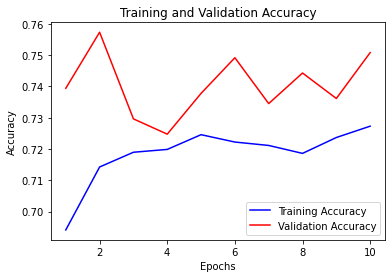

In [20]:
# Get the accuracy values from the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy graph
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()